In [42]:
%load_ext autoreload
%autoreload 2
# Prepare the environment
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run

    assert (
        run(["pip", "install", "easypip"]).returncode == 0
    ), "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=False)

import os
import copy
import numpy as np
import gymnasium as gym
import math
import bbrl_gymnasium  # noqa: F401
import torch
import torch.nn as nn
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl_utils.algorithms import EpochBasedAlgo
from bbrl_utils.nn import build_mlp, setup_optimizer, soft_update_params
from bbrl_utils.notebook import setup_tensorboard
from bbrl.visu.plot_policies import plot_policy
from omegaconf import OmegaConf
from td3_ddpg import DDPG, run_ddpg, TD3, run_td3
from utils import plot_metrics, plot_results, save_results_to_json
import matplotlib.pyplot as plt
from wrappers import FeatureFilterWrapper, ObsTimeExtensionWrapper, ActionTimeExtensionWrapper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/ddpg-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 1,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.8,
        "buffer_size": 1e6,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 6_000,
        # Minimum number of transitions before learning starts
        "learning_starts": 10_000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
}

In [39]:
def feature_filter_wrapper_1(env):
    """Wrapper pour enlever la première feature (par exemple, l'index 1)"""
    return FeatureFilterWrapper(env, 1)

def feature_filter_wrapper_3(env):
    """Wrapper pour enlever la troisième feature (par exemple, l'index 3)"""
    return FeatureFilterWrapper(env, 3)

def feature_filter_wrapper_both(env):
    """Wrapper pour enlever les deux features : première et troisième"""
    return FeatureFilterWrapper(FeatureFilterWrapper(env, 3), 1)

# Tests dans des environnements partiellement et complètement observables

In [40]:
def train_all_envs_and_algorithms(params):
    env_wrappers = {
        "full": [],
        "dx": [feature_filter_wrapper_1],
        "dtheta": [feature_filter_wrapper_3],
        "both": [feature_filter_wrapper_both],
    }
    
    results = {}
    
    # Entraînement avec DDPG
    for env_name, wrappers in env_wrappers.items():
        print(f"train with DDPG in the {env_name} env")
        
        # Initialiser l'algorithme DDPG avec l'environnement
        ddpg_instance = DDPG(OmegaConf.create(params), wrappers)
        critic_losses, actor_losses, rewards_per_step, steps, best_rewards, running_rewwards =run_ddpg(ddpg_instance)
        
        # Sauvegarder les résultats pour DDPG
        results[f"DDPG_{env_name}"] = {
            "critic_losses": critic_losses,
            "actor_losses": actor_losses,
            "rewards_per_step": rewards_per_step,
            "steps": steps,
            "best_rewards": best_rewards,
            "running_rewwards": running_rewwards
        }
    
    # Entraînement avec TD3
    for env_name, wrappers in env_wrappers.items():
        print(f"train with TD3 in the {env_name} env")
        
        # Initialiser l'algorithme TD3 avec l'environnement
        td3_instance = TD3(OmegaConf.create(params), wrappers)
        critic_losses, actor_losses, rewards_per_step, steps, best_rewards, running_rewwards = run_td3(td3_instance)
        
        # Sauvegarder les résultats pour TD3
        results[f"TD3_{env_name}"] = {
            "critic_losses": critic_losses,
            "actor_losses": actor_losses,
            "rewards_per_step": rewards_per_step,
            "steps": steps,
            "best_rewards": best_rewards,
            "running_rewwards": running_rewwards
        }
    
    return results

In [41]:
results = train_all_envs_and_algorithms(params)

train with DDPG in the full env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with DDPG in the dx env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with DDPG in the dtheta env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with DDPG in the both env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the full env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the dx env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the dtheta env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the both env


  0%|          | 0/6000 [00:00<?, ?it/s]

Plotting results for DDPG_full
Saved plot for DDPG_full at outputs/res1/DDPG_full_plot.png


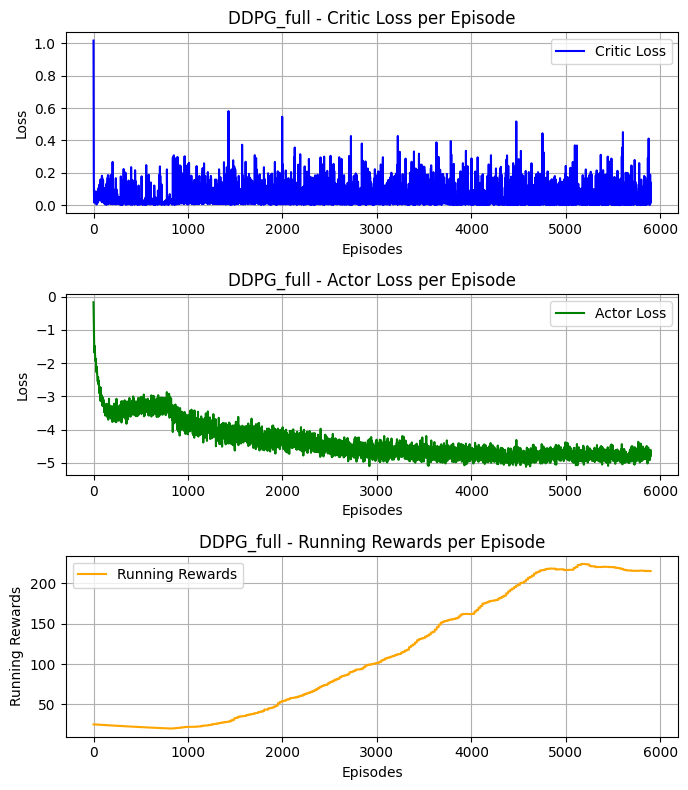

Plotting results for DDPG_dx
Saved plot for DDPG_dx at outputs/res1/DDPG_dx_plot.png


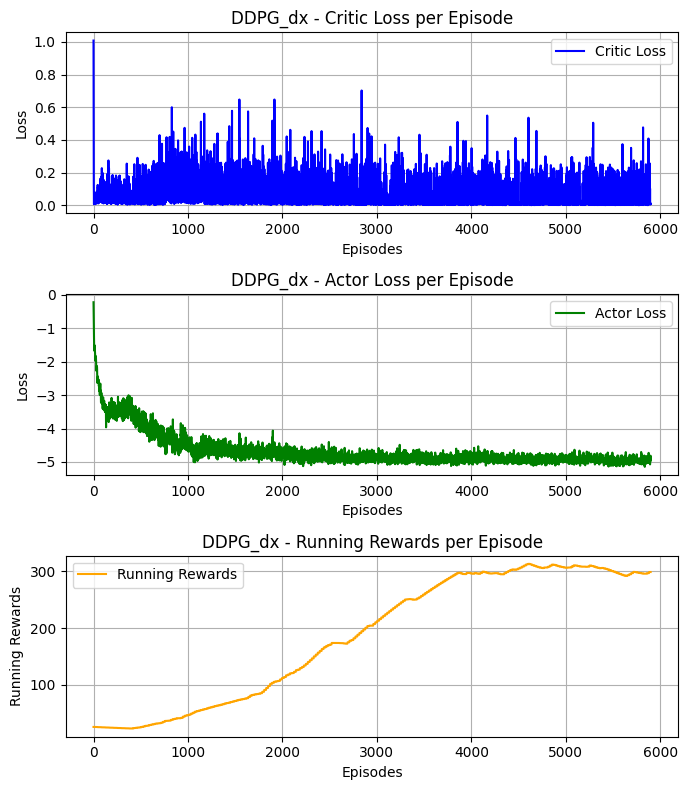

Plotting results for DDPG_dtheta
Saved plot for DDPG_dtheta at outputs/res1/DDPG_dtheta_plot.png


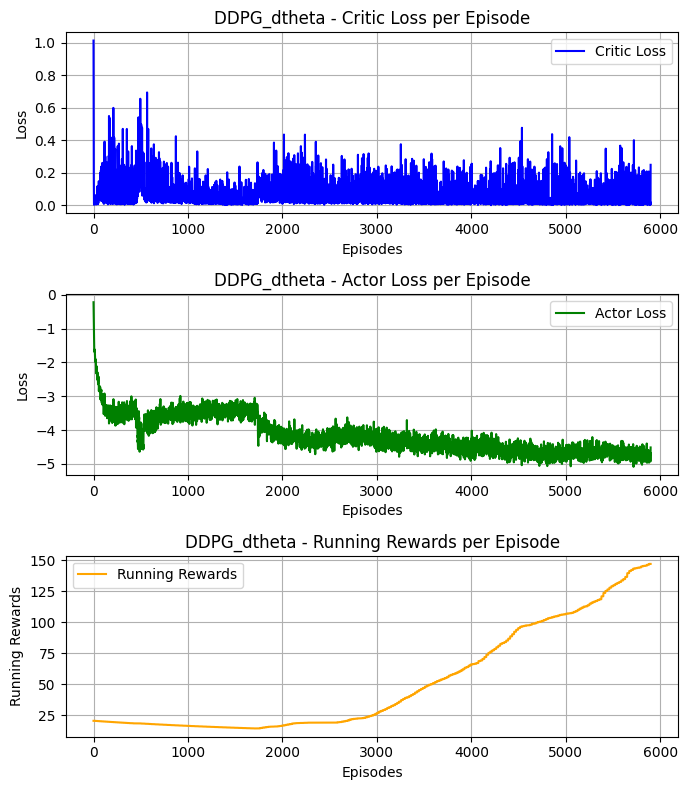

Plotting results for DDPG_both
Saved plot for DDPG_both at outputs/res1/DDPG_both_plot.png


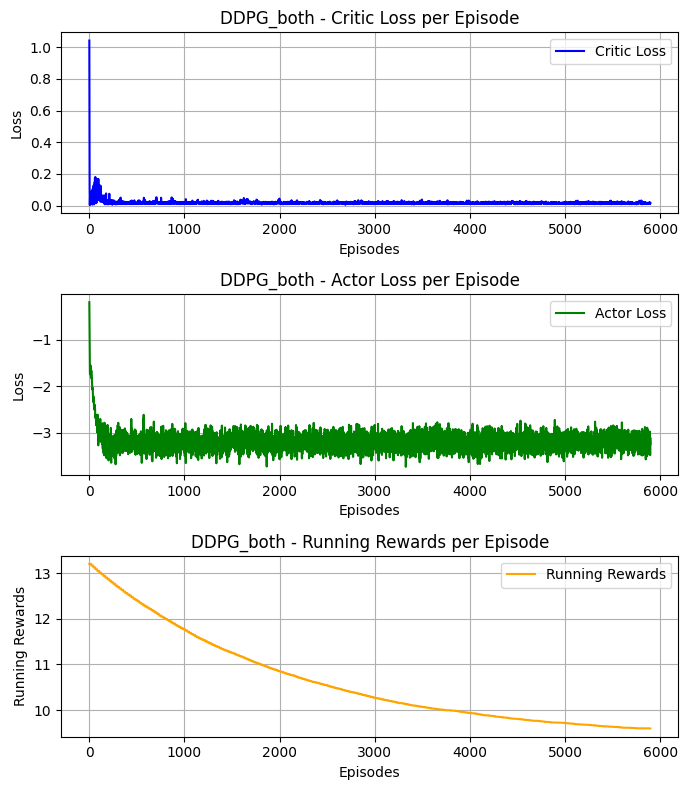

Plotting results for TD3_full
Saved plot for TD3_full at outputs/res1/TD3_full_plot.png


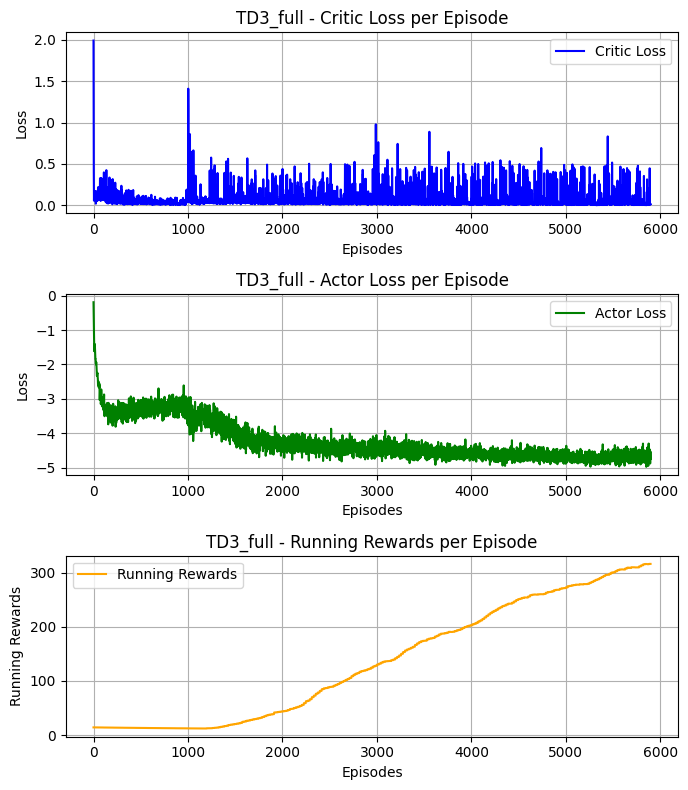

Plotting results for TD3_dx
Saved plot for TD3_dx at outputs/res1/TD3_dx_plot.png


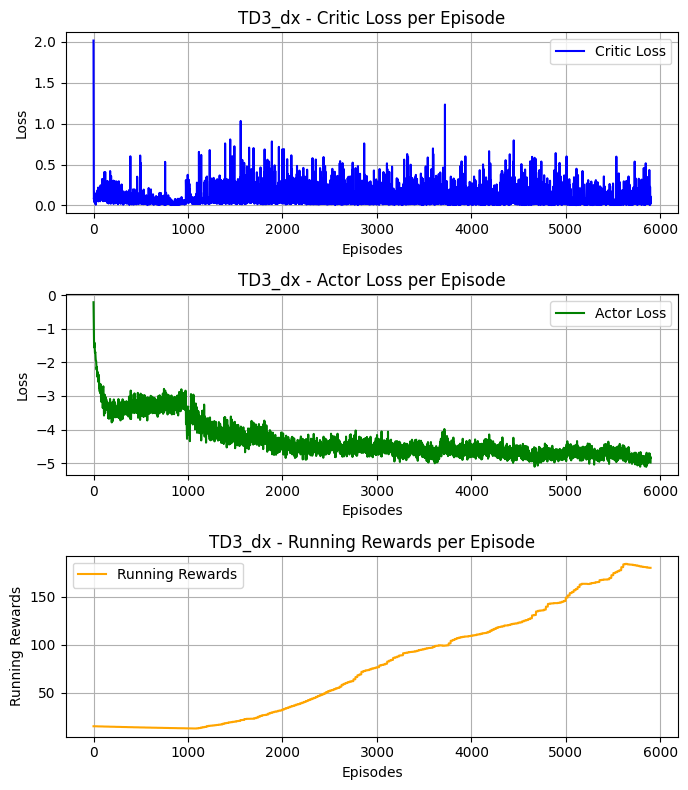

Plotting results for TD3_dtheta
Saved plot for TD3_dtheta at outputs/res1/TD3_dtheta_plot.png


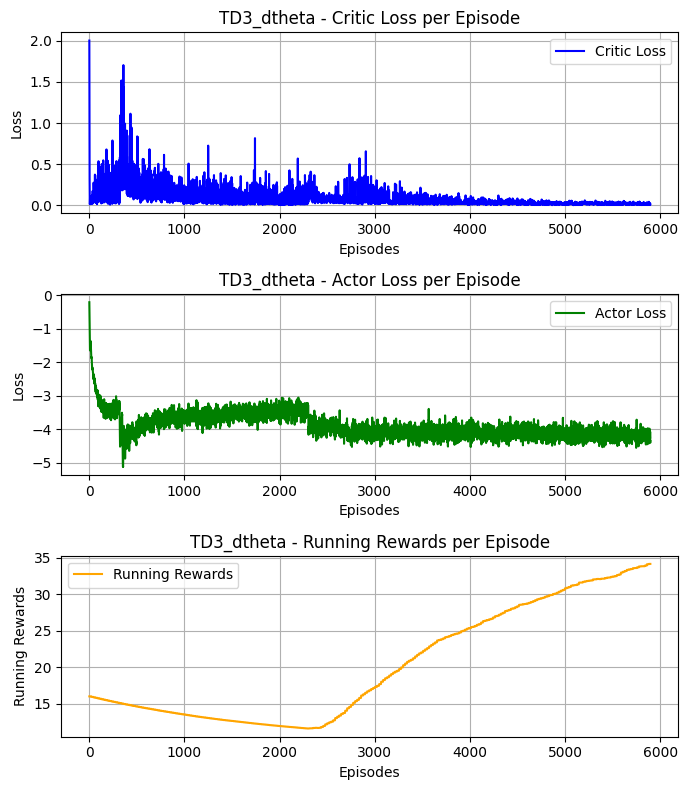

Plotting results for TD3_both
Saved plot for TD3_both at outputs/res1/TD3_both_plot.png


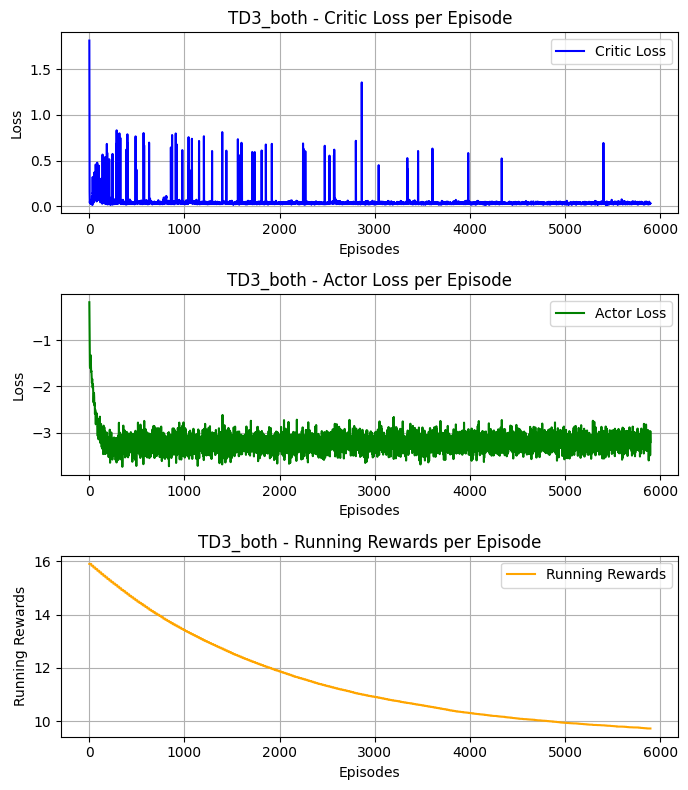

In [53]:
plot_results(results,"outputs/res1")

# Tests avec les wrappers dans les environnements partiellement observables

In [70]:
# Fonctions pour ObsTimeExtensionWrapper et ActionTimeExtensionWrapper avec feature filtering
memory_size=5
action_repeat=5
def obs_time_extension_wrapper_dx(env):
    """Appliquer ObsTimeExtensionWrapper avec mémoire et enlever la première feature."""
    return ObsTimeExtensionWrapper(feature_filter_wrapper_1(env), memory_size)

def obs_time_extension_wrapper_dtheta(env):
    """Appliquer ObsTimeExtensionWrapper avec mémoire et enlever la troisième feature."""
    return ObsTimeExtensionWrapper(feature_filter_wrapper_3(env), memory_size)

def obs_time_extension_wrapper_both(env):
    """Appliquer ObsTimeExtensionWrapper avec mémoire et enlever les deux features."""
    return ObsTimeExtensionWrapper(feature_filter_wrapper_both(env), memory_size)


def action_time_extension_wrapper_dx(env):
    """Appliquer ActionTimeExtensionWrapper avec répétition d'actions et enlever la première feature."""
    return ActionTimeExtensionWrapper(feature_filter_wrapper_1(env), action_repeat)

def action_time_extension_wrapper_dtheta(env):
    """Appliquer ActionTimeExtensionWrapper avec répétition d'actions et enlever la troisième feature."""
    return ActionTimeExtensionWrapper(feature_filter_wrapper_3(env), action_repeat)

def action_time_extension_wrapper_both(env):
    """Appliquer ActionTimeExtensionWrapper avec répétition d'actions et enlever les deux features."""
    return ActionTimeExtensionWrapper(feature_filter_wrapper_both(env), action_repeat)


def full_extension_wrapper_dx(env):
    """Appliquer ObsTimeExtensionWrapper, ActionTimeExtensionWrapper avec mémoire et actions répétées, et enlever la première feature."""
    return ObsTimeExtensionWrapper(ActionTimeExtensionWrapper(feature_filter_wrapper_1(env), action_repeat), memory_size)

def full_extension_wrapper_dtheta(env):
    """Appliquer ObsTimeExtensionWrapper, ActionTimeExtensionWrapper avec mémoire et actions répétées, et enlever la troisième feature."""
    return ObsTimeExtensionWrapper(ActionTimeExtensionWrapper(feature_filter_wrapper_3(env), action_repeat), memory_size)

def full_extension_wrapper_both(env):
    """Appliquer ObsTimeExtensionWrapper, ActionTimeExtensionWrapper avec mémoire et actions répétées, et enlever les deux features."""
    return ObsTimeExtensionWrapper(ActionTimeExtensionWrapper(feature_filter_wrapper_both(env), action_repeat), memory_size)


In [71]:
def train_all_envs_and_algorithms_with_extension(params):
    wrappers_envs_with_extensions = {
        "dx_obs_ext": [obs_time_extension_wrapper_dx],
        "dtheta_obs_ext": [obs_time_extension_wrapper_dtheta],
        "both_obs_ext": [obs_time_extension_wrapper_both],
        "dx_act_ext": [action_time_extension_wrapper_dx],
        "dtheta_act_ext": [action_time_extension_wrapper_dtheta],
        "both_act_ext": [action_time_extension_wrapper_both],
        "dx_full_ext": [full_extension_wrapper_dx],
        "dtheta_full_ext": [full_extension_wrapper_dtheta],
        "both_full_ext": [full_extension_wrapper_both]
    }
    
    results_with_extensions = {}
    
    # Entraînement avec DDPG
    for env_name, wrappers in wrappers_envs_with_extensions.items():
        print(f"train with DDPG in the {env_name} env")
        
        # Initialiser l'algorithme DDPG avec l'environnement
        ddpg_instance = DDPG(OmegaConf.create(params), wrappers)
        critic_losses, actor_losses, rewards_per_step, steps, best_rewards, running_rewwards =run_ddpg(ddpg_instance)
        
        # Sauvegarder les résultats pour DDPG
        results_with_extensions[f"DDPG_{env_name}"] = {
            "critic_losses": critic_losses,
            "actor_losses": actor_losses,
            "rewards_per_step": rewards_per_step,
            "steps": steps,
            "best_rewards": best_rewards,
            "running_rewwards": running_rewwards
        }
    
    # Entraînement avec TD3
    for env_name, wrappers in wrappers_envs_with_extensions.items():
        print(f"train with TD3 in the {env_name} env")
        
        # Initialiser l'algorithme TD3 avec l'environnement
        td3_instance = TD3(OmegaConf.create(params), wrappers)
        critic_losses, actor_losses, rewards_per_step, steps, best_rewards, running_rewwards = run_td3(td3_instance)
        
        # Sauvegarder les résultats pour TD3
        results_with_extensions[f"TD3_{env_name}"] = {
            "critic_losses": critic_losses,
            "actor_losses": actor_losses,
            "rewards_per_step": rewards_per_step,
            "steps": steps,
            "best_rewards": best_rewards,
            "running_rewwards": running_rewwards
        }
    
    return results_with_extensions

In [72]:
results_with_extensions = train_all_envs_and_algorithms_with_extension(params)

train with DDPG in the dx_obs_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with DDPG in the dtheta_obs_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with DDPG in the both_obs_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with DDPG in the dx_act_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with DDPG in the dtheta_act_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with DDPG in the both_act_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with DDPG in the dx_full_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with DDPG in the dtheta_full_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with DDPG in the both_full_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the dx_obs_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the dtheta_obs_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the both_obs_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the dx_act_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the dtheta_act_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the both_act_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the dx_full_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the dtheta_full_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

train with TD3 in the both_full_ext env


  0%|          | 0/6000 [00:00<?, ?it/s]

Plotting results for DDPG_dx_obs_ext
Saved plot for DDPG_dx_obs_ext at outputs/res2/DDPG_dx_obs_ext_plot.png


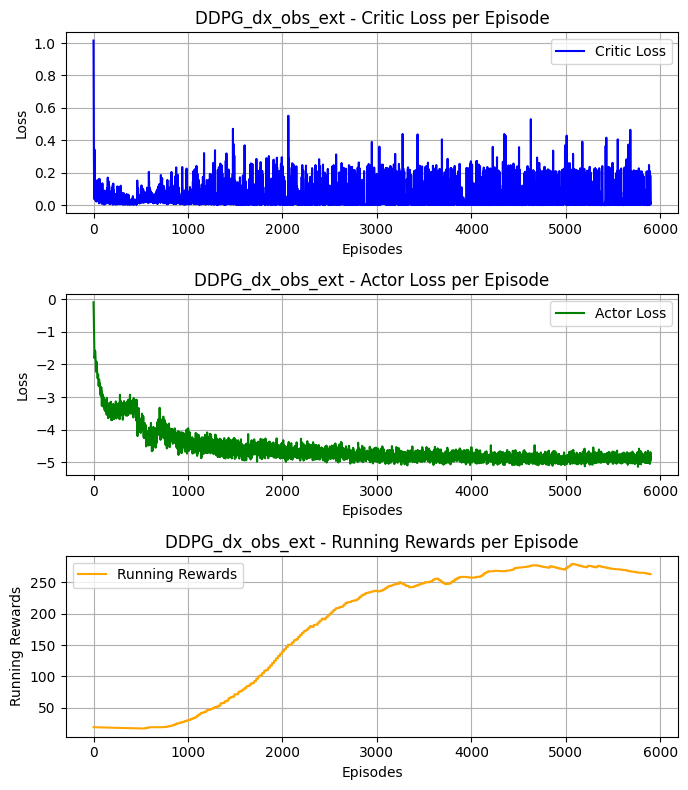

Plotting results for DDPG_dtheta_obs_ext
Saved plot for DDPG_dtheta_obs_ext at outputs/res2/DDPG_dtheta_obs_ext_plot.png


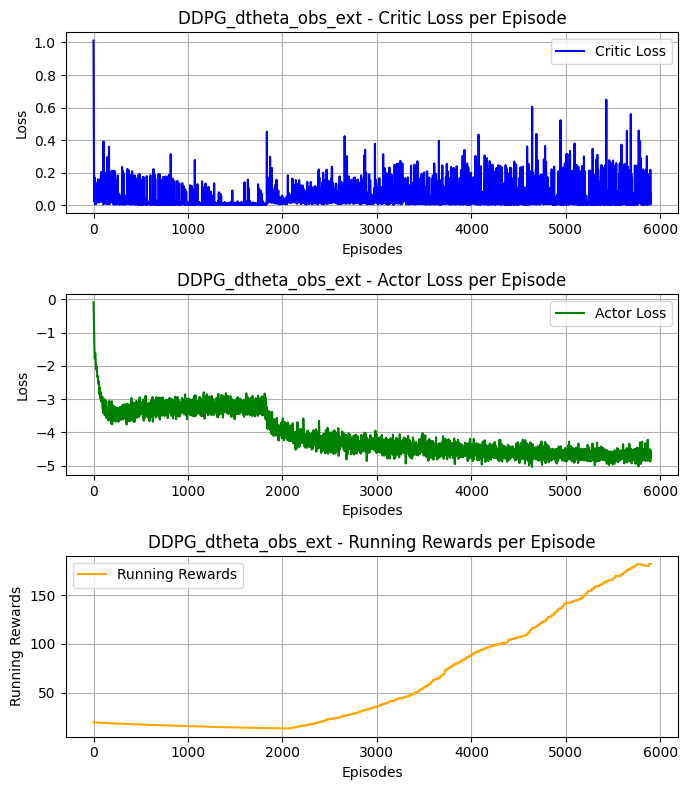

Plotting results for DDPG_both_obs_ext
Saved plot for DDPG_both_obs_ext at outputs/res2/DDPG_both_obs_ext_plot.png


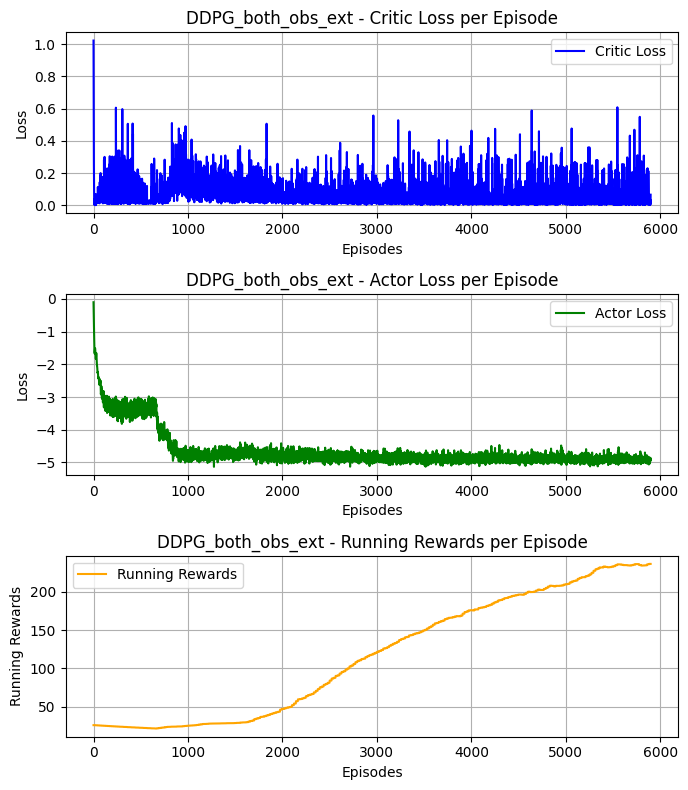

Plotting results for DDPG_dx_act_ext
Saved plot for DDPG_dx_act_ext at outputs/res2/DDPG_dx_act_ext_plot.png


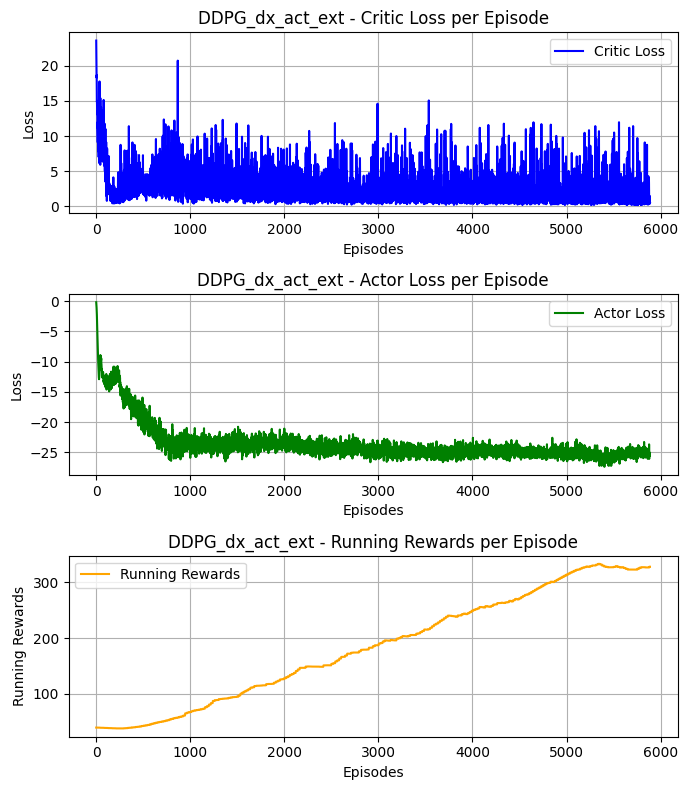

Plotting results for DDPG_dtheta_act_ext
Saved plot for DDPG_dtheta_act_ext at outputs/res2/DDPG_dtheta_act_ext_plot.png


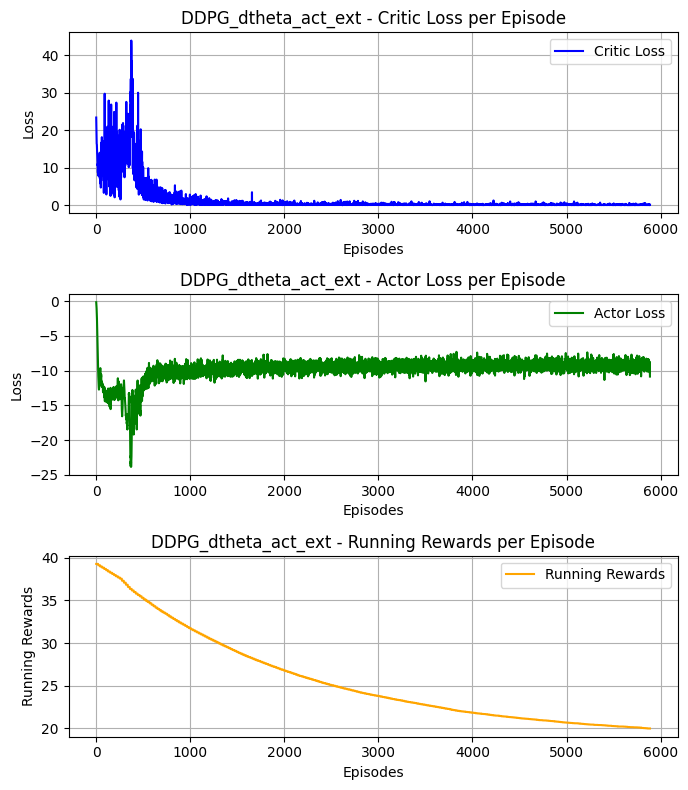

Plotting results for DDPG_both_act_ext
Saved plot for DDPG_both_act_ext at outputs/res2/DDPG_both_act_ext_plot.png


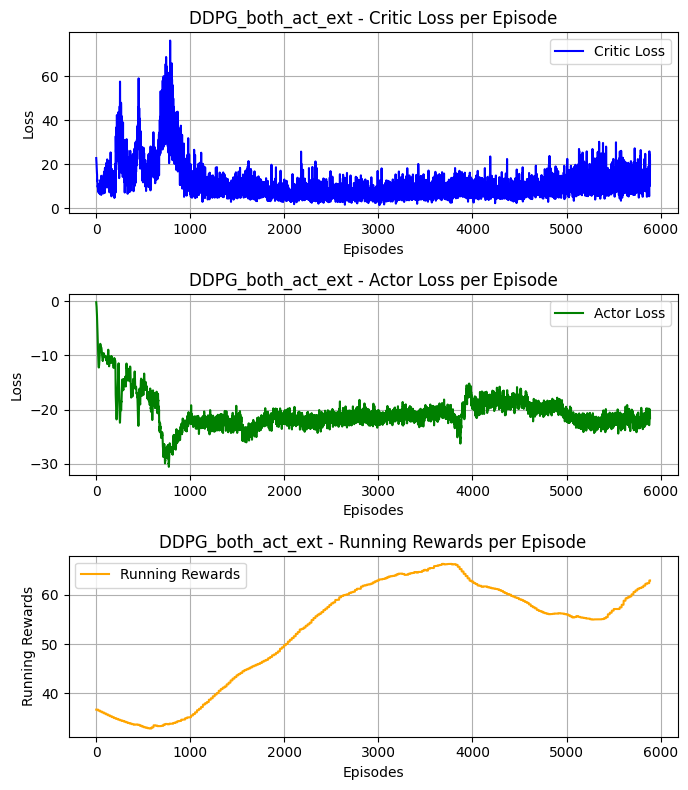

Plotting results for DDPG_dx_full_ext
Saved plot for DDPG_dx_full_ext at outputs/res2/DDPG_dx_full_ext_plot.png


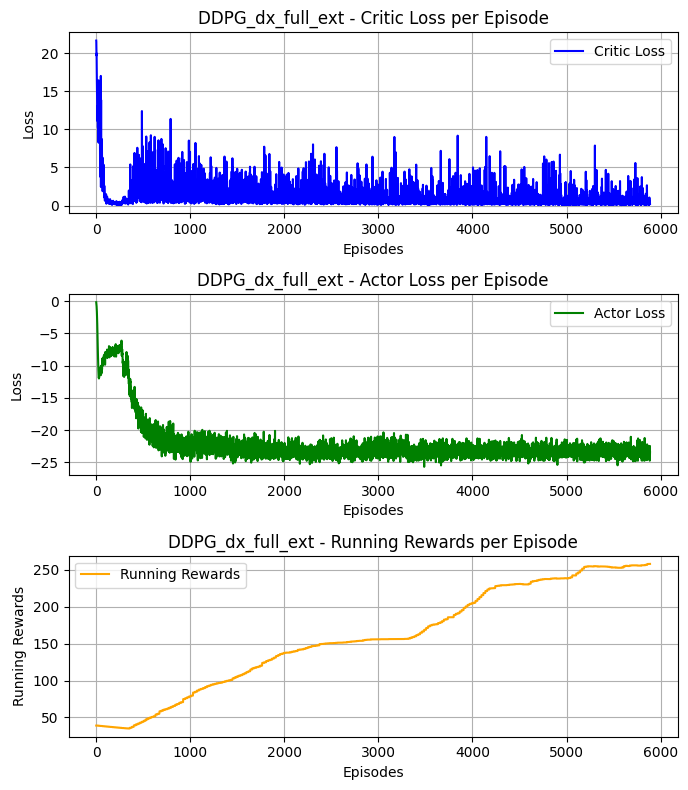

Plotting results for DDPG_dtheta_full_ext
Saved plot for DDPG_dtheta_full_ext at outputs/res2/DDPG_dtheta_full_ext_plot.png


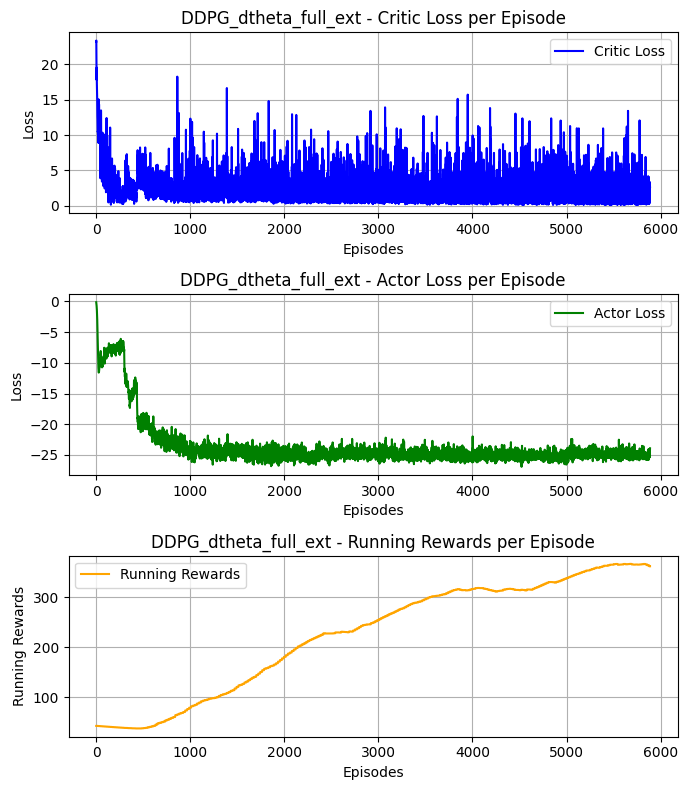

Plotting results for DDPG_both_full_ext
Saved plot for DDPG_both_full_ext at outputs/res2/DDPG_both_full_ext_plot.png


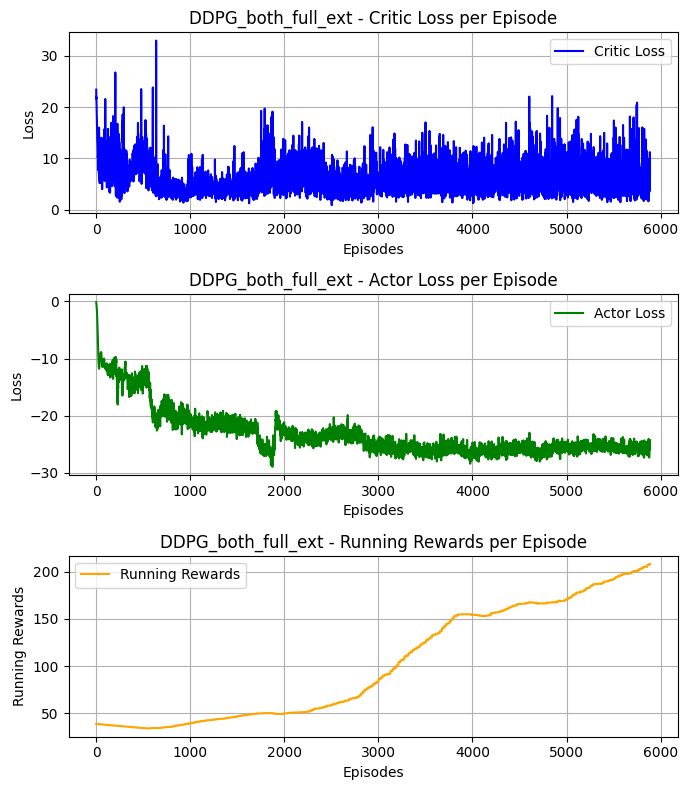

Plotting results for TD3_dx_obs_ext
Saved plot for TD3_dx_obs_ext at outputs/res2/TD3_dx_obs_ext_plot.png


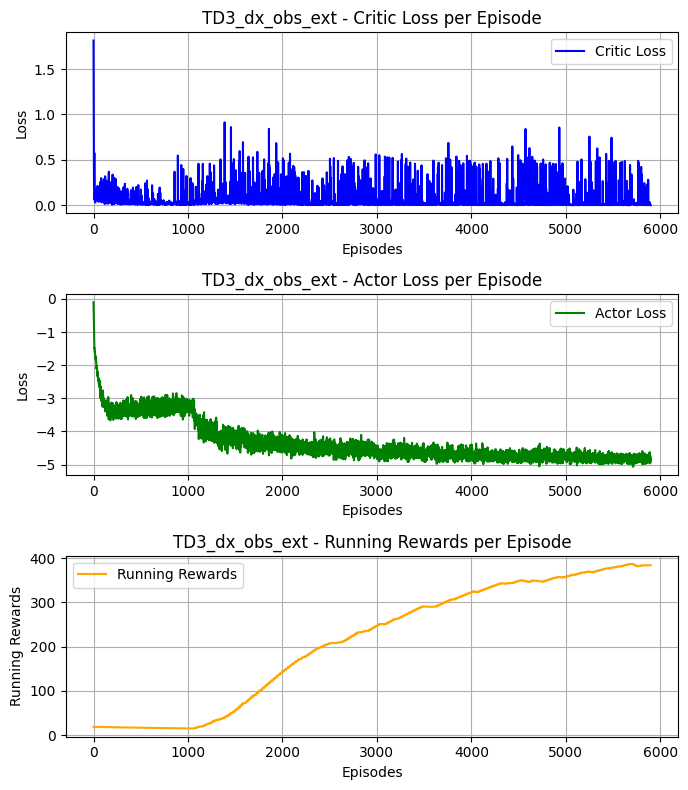

Plotting results for TD3_dtheta_obs_ext
Saved plot for TD3_dtheta_obs_ext at outputs/res2/TD3_dtheta_obs_ext_plot.png


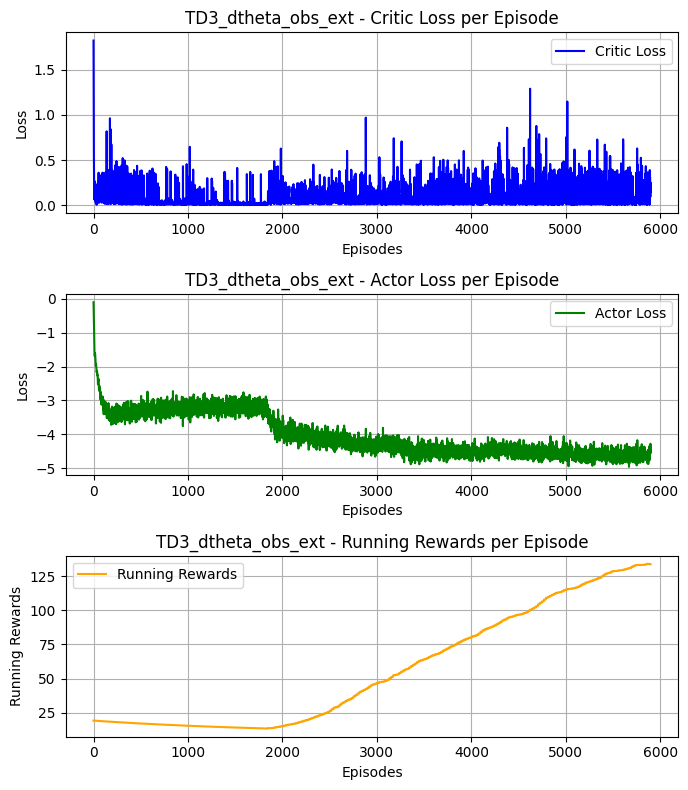

Plotting results for TD3_both_obs_ext
Saved plot for TD3_both_obs_ext at outputs/res2/TD3_both_obs_ext_plot.png


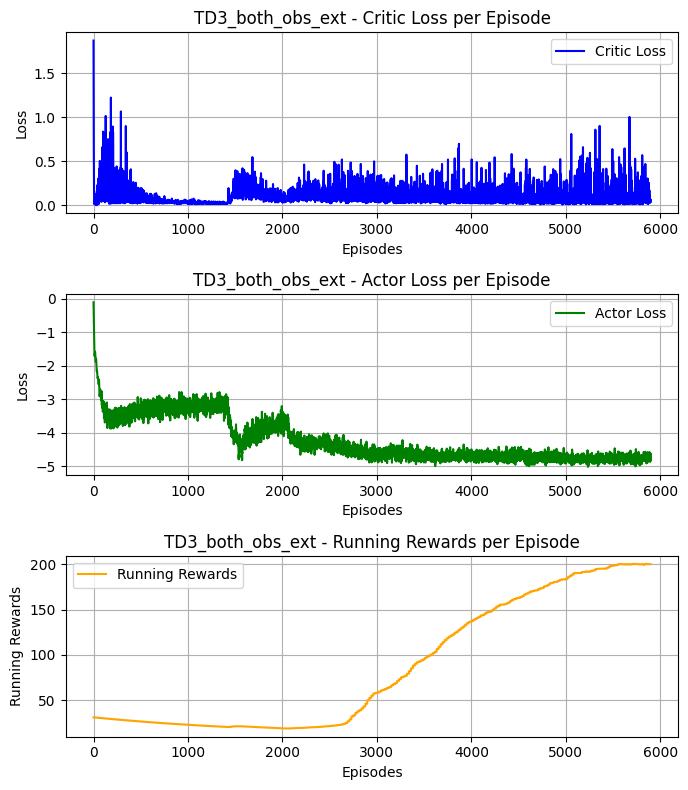

Plotting results for TD3_dx_act_ext
Saved plot for TD3_dx_act_ext at outputs/res2/TD3_dx_act_ext_plot.png


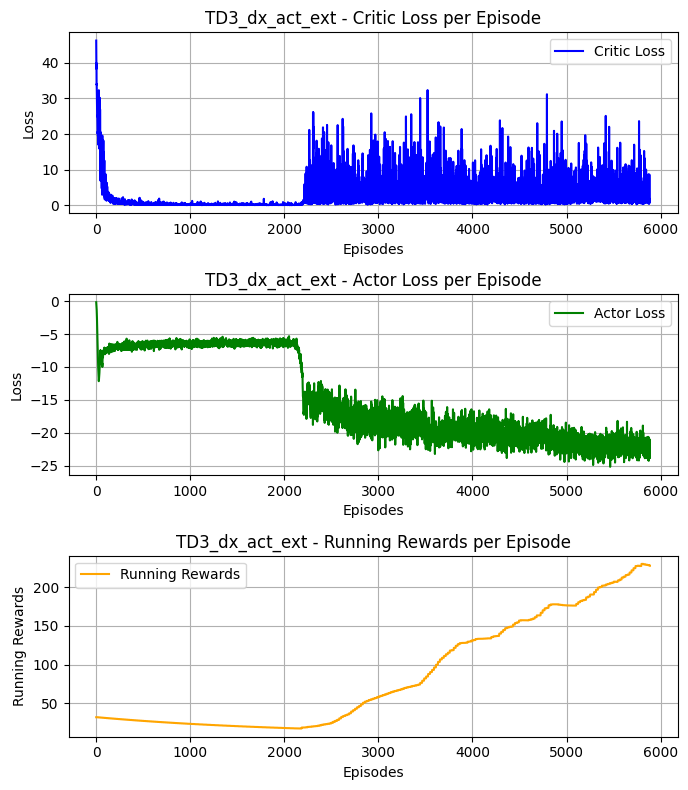

Plotting results for TD3_dtheta_act_ext
Saved plot for TD3_dtheta_act_ext at outputs/res2/TD3_dtheta_act_ext_plot.png


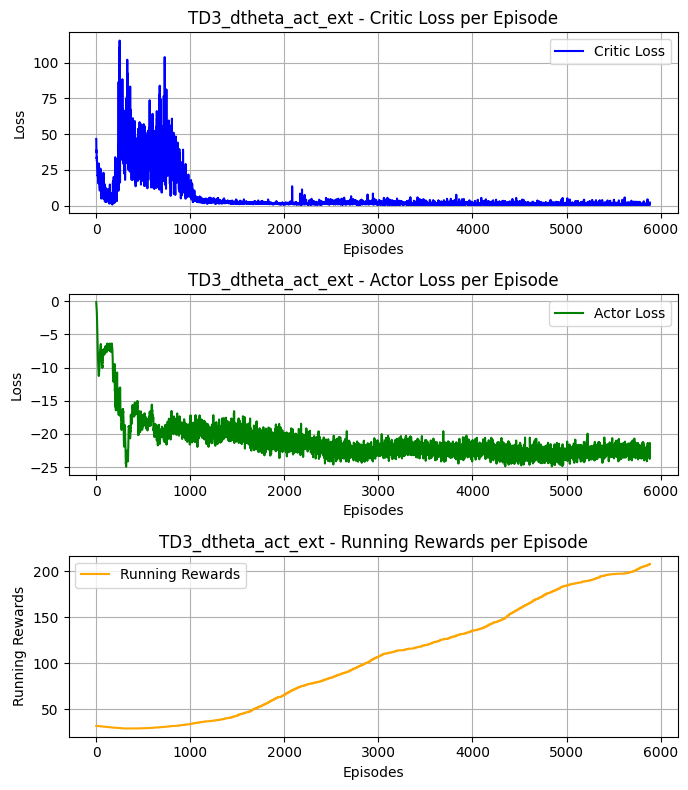

Plotting results for TD3_both_act_ext
Saved plot for TD3_both_act_ext at outputs/res2/TD3_both_act_ext_plot.png


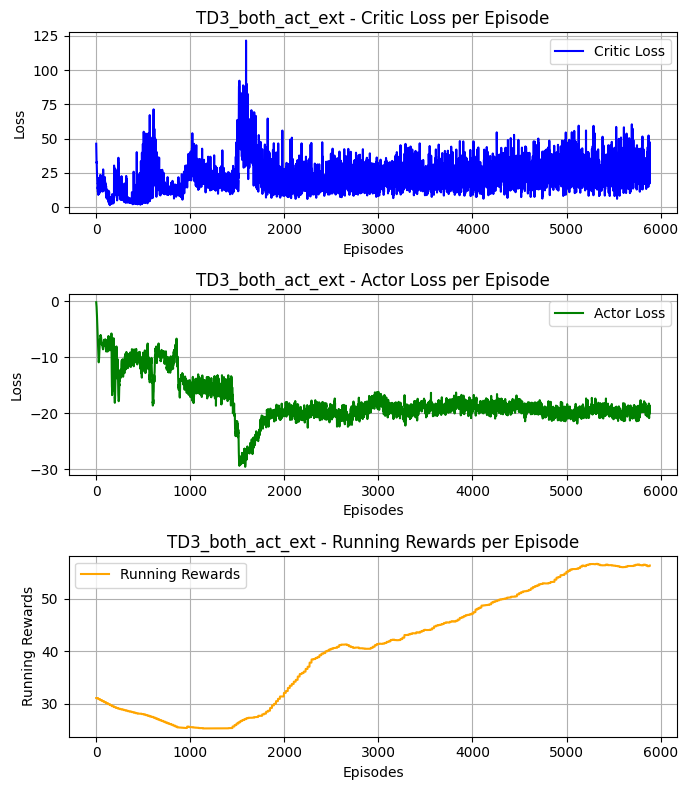

Plotting results for TD3_dx_full_ext
Saved plot for TD3_dx_full_ext at outputs/res2/TD3_dx_full_ext_plot.png


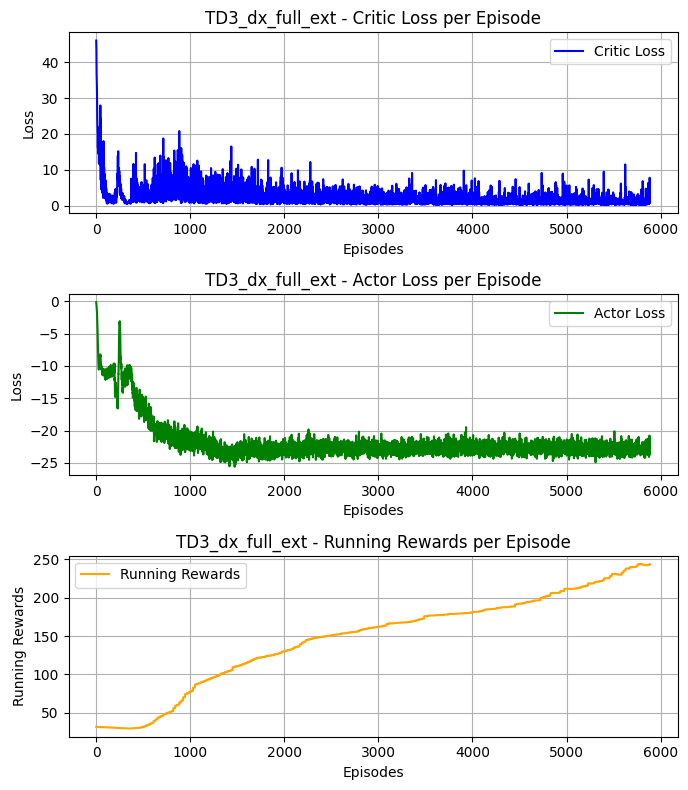

Plotting results for TD3_dtheta_full_ext
Saved plot for TD3_dtheta_full_ext at outputs/res2/TD3_dtheta_full_ext_plot.png


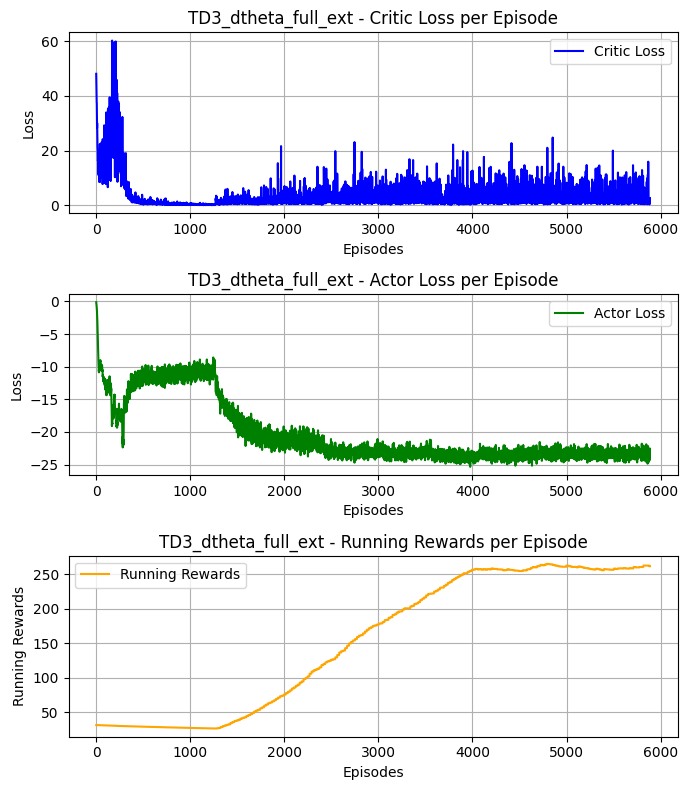

Plotting results for TD3_both_full_ext
Saved plot for TD3_both_full_ext at outputs/res2/TD3_both_full_ext_plot.png


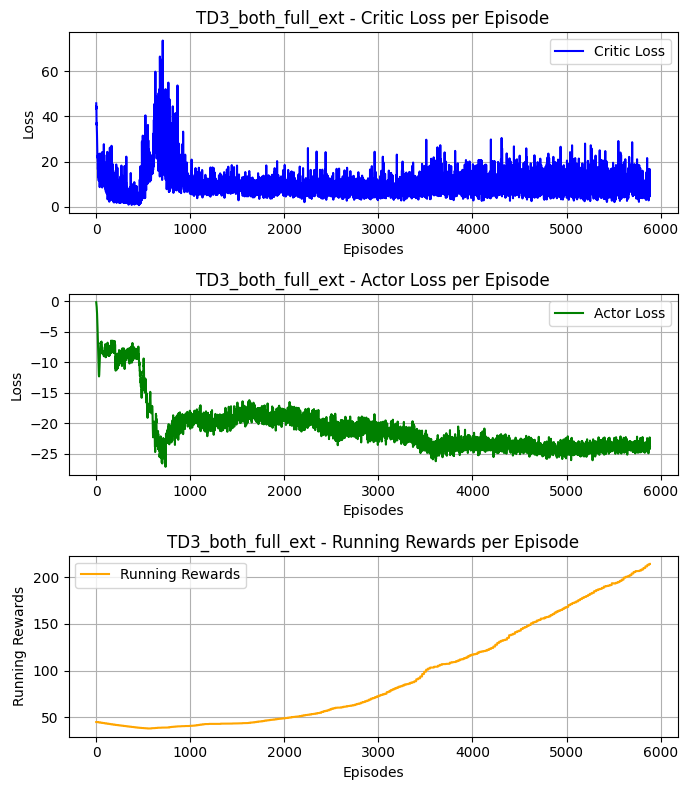

In [73]:
plot_results(results_with_extensions,"outputs/res2")